**Salary** **Multiclassification** **Analysis** **Project**: 

The data source used for this project is '2021 Kaggle Machine Learning & Data Science Survey' dataset. 

This project aims to apply the ordinal logisitic regression and cross validation technique to classify the professionals working in data science into different salary levels based on relevant survey responses. 

In [ ]:
#import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import files 
uploaded = files.upload()
#Read data into python 
df = pd.read_csv("clean_kaggle_data_2021.csv", low_memory = False)
df.head()


Saving clean_kaggle_data_2021.csv to clean_kaggle_data_2021 (1).csv


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"


# 1. Data Cleaning 

In [ ]:
#Drop column "duration of finishing survey" since it has no relationship with latter salary analysis
#Drop column "Q8: what programming language would you recommend an aspring data scientist to learn first" since it has no relationship with latter salary analysis
#Drop column "Q28: favorite developer tool" since it has no relationship with latter salary analysis
#Drop column Q25 since Q25_buckets has included data in Q25 
df.drop(columns = ["Q8",'Time from Start to Finish (seconds)', 'Q25', 'Q28'], inplace = True)


## Encoding 
### Main Logic: 
### For all categorical variables in data, separate these categorical variables (columns) into: 
### 1. categorical variables with natural ranking (ordinal) -- Ordinal encoding 
### 2. categorical variables without natural ranking (nominal) -- one hot encoding 

## Handle missing values: 
### Main Logic: 
### Before encoding each single column, we will firstly deal with missing values either by drop whole columns or by filling missing values with mode.

In [ ]:
#Sperate columns into single columns and multi - columns so that I can appply different encoding methods to different types of columns 
#Single columns 
single_cols = [x for x in list(df.columns) if ("Part" not in x and "OTHER" not in x )]

#Store the information referring to the 'meaning of each column' in the dictionary to faciliate latter analysis 
single_cols_info = {x:df[x][:1].values[0] for x in single_cols}
#single_cols_info


In [ ]:
#Multi-columns
multi_cols = [x for x in list(df.columns) if x not in single_cols]
#Store the information referring to the 'meaning of each column' in the dictionary to faciliate latter analysis 
multi_cols_info = {x:df[x][:1].values[0] for x in multi_cols}
#multi_cols_info

In [ ]:
#Drop the first 'question' row 
df.drop(index = 0, inplace= True)

### For those single columns:
### Some columns needs one hot coding, others need ordinal coding. 
### columns needing ordinal encoding: 
    Q1: Age Group 
    Q4: Education level 
    Q6: Years of programming 
    Q13: Times of using TPU
    Q15: Years of using ML
    Q21: Size of Company 
    Q22: Data Science workloads  
    Q23: The duration of incoporating ML into business 
    Q26: Money Spent on ML and cloud computing
    
    
### columns needing one hot encoding: 
     Q2: Gender 
     Q3: Country 
     Q5: Job
     Q11: Type of computing platform used 
     Q20: Industry of Company 
     Q33: Data based used 
     Q35: Business Intelligence tool used often 
     Q41: Primary tool used to analyze data 
     

### For those multi-columns:
### All muti columns needs one hot encoding since they do not have ordinal features 
### Multi-columns needing one hot encoding: 
    Q7, Q9, Q10, Q12, Q14, Q16, Q17, Q18, Q19, Q24, Q27, Q29, Q30, Q31, Q32, Q34, Q36, Q37, Q38, Q39, Q40, Q42. 
    

In [ ]:
#Encode columns 
#To create the dataframe including all encoded columns 
df2 = pd.DataFrame(df['Q25_Encoded'])

#For single columns, separate the columns that need one hot encoding and the columns that need ordinal encoding 
ordinal_cols = ['Q1', 'Q4', 'Q6', 'Q13', 'Q15','Q21','Q22','Q23','Q26']
one_hot_cols = ['Q2', 'Q3', 'Q5', 'Q11', 'Q20', 'Q33', 'Q35', 'Q41']

### Below is the encoding process for single columns that need one hot coding:

### Step 1: Handle missing values for single columns that need one hot encoding 

In [ ]:
###Before processing specific columns with one hot encoding, we handle missing values in those columns 
df[one_hot_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15391 entries, 1 to 15391
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q2      15391 non-null  object
 1   Q3      15391 non-null  object
 2   Q5      15391 non-null  object
 3   Q11     14430 non-null  object
 4   Q20     15391 non-null  object
 5   Q33     4656 non-null   object
 6   Q35     2237 non-null   object
 7   Q41     13426 non-null  object
dtypes: object(8)
memory usage: 1.1+ MB


In [ ]:
# Drop Q33, Q35 since these two columns has most of null values (Null values are too much)
# It is meaningless to conduct analysis with columns having most of null values 
df.drop(columns = ['Q33', 'Q35'], inplace = True)

In [ ]:
# Check the mode in Q11 
df['Q11'].value_counts()

A laptop                                                               8771
A personal computer / desktop                                          3095
A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)    1705
A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)               593
None                                                                    144
Other                                                                   122
Name: Q11, dtype: int64

In [ ]:
# Fill missing values in Q11 with mode 
df['Q11'].fillna('A laptop', inplace = True)

In [ ]:
#Check Q11 has no missing values now
df['Q11'].isnull().sum()

0

In [ ]:
#Check the mode in Q41 
df['Q41'].value_counts()

Local development environments (RStudio, JupyterLab, etc.)              5146
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       4967
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     994
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 836
Advanced statistical software (SPSS, SAS, etc.)                          746
Other                                                                    737
Name: Q41, dtype: int64

In [ ]:
#Fill missing values in Q41 with mode 
df['Q41'].fillna('Local development environments (RStudio, JupyterLab, etc.)', inplace = True)

In [ ]:
#Check Q41 has no missing values now
df['Q41'].isnull().sum()

0

### Step 2: Process specific single columns with one hot encoding 

In [ ]:
#One hot encode single columns 
# modify Q2 to facilitate men vs women analysis 
df['Q2'] = df['Q2'].map({'Man':'Man', 'Woman':'Woman'}).fillna('Other')

#create dummy variable (0 or 1) for Q2:Gender 
dummy1 = pd.get_dummies(df['Q2'], prefix = 'Q2')

In [ ]:
#create dummy variable (0 or 1) for Q3: Coountry 
dummy2 = pd.get_dummies(df['Q3'], prefix = 'Q3')

In [ ]:
#create dummy variable (0 or 1) for Q5: Job
dummy3 = pd.get_dummies(df['Q5'], prefix = 'Q5')

In [ ]:
#create dummy variable (0 or 1) for Q11: Type of Computing platform used 
dummy4 = pd.get_dummies(df['Q11'], prefix = 'Q11')

In [ ]:
#create dummy variable (0 or 1) for Q20: Industry of company 
dummy5 = pd.get_dummies(df['Q20'], prefix = 'Q20')

In [ ]:
#create dummy variable (0 or 1) for Q41: Primary tool used to analyze data 
dummy7 = pd.get_dummies(df['Q41'], prefix = 'Q41')

In [ ]:
#Concatenate all dummies with df2 
df2 = pd.concat([df2, dummy1, dummy2, dummy3, dummy4, dummy5,dummy7],axis = 1)

### Below is the encoding process for single columns that need ordinal coding:

### Step 1:  Handle missing values for single columns that need ordinal encoding 

In [ ]:
df[ordinal_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15391 entries, 1 to 15391
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q1      15391 non-null  object
 1   Q4      15391 non-null  object
 2   Q6      15391 non-null  object
 3   Q13     14430 non-null  object
 4   Q15     14430 non-null  object
 5   Q21     15391 non-null  object
 6   Q22     15391 non-null  object
 7   Q23     15391 non-null  object
 8   Q26     15183 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB


In [ ]:
# Check the mode in Q13 
df['Q13'].value_counts()

Never                 9255
2-5 times             2268
Once                  1840
6-25 times             625
More than 25 times     442
Name: Q13, dtype: int64

In [ ]:
# Fill the missing values in Q13 with mode 
df['Q13'].fillna('Never', inplace = True)

In [ ]:
# Check no missing value in Q13 now
df['Q13'].isnull().sum()

0

In [ ]:
# Check the mode in Q15
df['Q15'].value_counts()

Under 1 year                             4514
1-2 years                                2970
I do not use machine learning methods    1867
2-3 years                                1784
3-4 years                                 967
5-10 years                                960
4-5 years                                 845
10-20 years                               339
20 or more years                          184
Name: Q15, dtype: int64

In [ ]:
# Fill the missing values in Q15 with mode 
df['Q15'].fillna('Under 1 year', inplace = True)

In [ ]:
# Check no missing value in Q15
df['Q15'].isnull().sum()

0

In [ ]:
# Check the mode in Q26
df['Q26'].value_counts()

$0 ($USD)                  5903
$100-$999                  2534
$1000-$9,999               2491
$1-$99                     1929
$10,000-$99,999            1309
$100,000 or more ($USD)    1017
Name: Q26, dtype: int64

In [ ]:
# Fill the missing values in Q26 with mode 
df['Q26'].fillna('$0 ($USD)', inplace = True)

In [ ]:
# Check no missing value in Q26
df['Q26'].isnull().sum()

0

### Step 2: Process specific single columns with ordinal encoding

In [ ]:
df['Q1'].value_counts()

25-29    3235
30-34    2626
22-24    2092
35-39    1992
40-44    1528
45-49    1141
18-21     931
50-54     791
55-59     504
60-69     454
70+        97
Name: Q1, dtype: int64

In [ ]:
# Ordinally encode single columns 
# Create ordered numbers for Q1: Age Group 
df2['Q1'] = df['Q1'].map({'18-21':0, "22-24":1, "25-29":2, "30-34":3,"35-39":4, "40-44":5,"45-49":6,
                         "50-54":7,"55-59":8,"60-69":9,"70+":10})

In [ ]:
df['Q4'].value_counts()

Master’s degree                                                      6799
Bachelor’s degree                                                    4777
Doctoral degree                                                      2217
Some college/university study without earning a bachelor’s degree     746
I prefer not to answer                                                334
Professional doctorate                                                290
No formal education past high school                                  228
Name: Q4, dtype: int64

In [ ]:
# Create ordered numbers for Q4: Education 
df2['Q4'] = df['Q4'].map({'No formal education past high school' :0,
                          'Some college/university study without earning a bachelor’s degree': 1,
                         'Bachelor’s degree': 2,
                         'Master’s degree': 3,
                         'Doctoral degree': 4,
                         'Professional doctorate': 5, 
                         'I prefer not to answer': 3})

In [ ]:
df['Q6'].value_counts()

1-3 years                    3691
< 1 years                    2463
3-5 years                    2461
5-10 years                   2345
10-20 years                  1846
20+ years                    1624
I have never written code     961
Name: Q6, dtype: int64

In [ ]:
# Create ordered numbers for Q6: Years of programming 
df2['Q6'] = df['Q6'].map({'I have never written code': 0, '< 1 years': 1, '1-3 years': 2, 
                                    '3-5 years': 3, '5-10 years': 4, 
                                    '10-20 years':5, '20+ years': 6})

In [ ]:
df['Q13'].value_counts()

Never                 10216
2-5 times              2268
Once                   1840
6-25 times              625
More than 25 times      442
Name: Q13, dtype: int64

In [ ]:
# create ordered numbers for Q13: Times of using TPU
df2['Q13'] = df['Q13'].map({'Never': 0, 'Once': 1, 
                                    '2-5 times': 2, '6-25 times': 3, 
                                    'More than 25 times':4})

In [ ]:
df['Q15'].value_counts()

Under 1 year                             5475
1-2 years                                2970
I do not use machine learning methods    1867
2-3 years                                1784
3-4 years                                 967
5-10 years                                960
4-5 years                                 845
10-20 years                               339
20 or more years                          184
Name: Q15, dtype: int64

In [ ]:
# create ordered numbers for Q15: Years of ML
df2['Q15'] = df['Q15'].map({'I do not use machine learning methods': 0, 'Under 1 year': 1, '1-2 years': 2, 
                            '2-3 years': 3, '3-4 years': 4, '4-5 years':5, 
                            '5-10 years': 6,'10-20 years': 7, '20 or more years': 8}
                           )

In [ ]:
df['Q21'].value_counts()

0-49 employees              4683
10,000 or more employees    3236
1000-9,999 employees        2928
50-249 employees            2476
250-999 employees           2068
Name: Q21, dtype: int64

In [ ]:
# create ordered numbers for Q21: Size of company
df2['Q21'] = df['Q21'].map({'0-49 employees': 1, '50-249 employees': 5, 
                                        '250-999 employees': 20, 
                                        '1000-9,999 employees': 200, 
                                        '10,000 or more employees': 250})

In [ ]:
df['Q22'].value_counts()

1-2      3483
20+      3435
0        2876
3-4      2453
5-9      1782
10-14     957
15-19     405
Name: Q22, dtype: int64

In [ ]:
# create ordered numbers for Q22: Data Science workload of business 
df2['Q22']= df['Q22'].map({'0': 0,
               '1-2': 1,
               '3-4': 2,
               '5-9': 3,
               '10-14': 4,
               '15-19':5,
                '20+': 6})

In [ ]:
df['Q23'].value_counts()

We are exploring ML methods (and may one day put a model into production)                    3285
No (we do not use ML methods)                                                                3161
I do not know                                                                                2550
We have well established ML methods (i.e., models in production for more than 2 years)       2546
We recently started using ML methods (i.e., models in production for less than 2 years)      2196
We use ML methods for generating insights (but do not put working models into production)    1653
Name: Q23, dtype: int64

In [ ]:
# create ordered numbers for Q23: The duration of incoporating ML into business 
df2['Q23']= df['Q23'].map({'No (we do not use ML methods)': 0,
               'We are exploring ML methods (and may one day put a model into production)': 1,
               'We use ML methods for generating insights (but do not put working models into production)': 2,
               'We recently started using ML methods (i.e., models in production for less than 2 years)': 3,
               'We have well established ML methods (i.e., models in production for more than 2 years)': 4,
               'I do not know':1})


In [ ]:
df['Q26'].value_counts()

$0 ($USD)                  6111
$100-$999                  2534
$1000-$9,999               2491
$1-$99                     1929
$10,000-$99,999            1309
$100,000 or more ($USD)    1017
Name: Q26, dtype: int64

In [ ]:
# Create ordered numbers for Q26: Money spent on ML and cloud computing 
df2['Q26'] = df['Q26'].map({'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 10, 
                            '$1000-$9,999': 100, '$10,000-$99,999': 1000, 
                            '$100,000 or more ($USD)':2000}).fillna(df['Q26'])

In [ ]:
# Check if has null values to ensure missing values in those single columns are all handled
df2.columns[df2.isnull().any()].tolist()

[]

### Below is the encoding process for multi-columns: 

### Step 1: Process muti-columns with one hot encoding directly 

In [ ]:
#hide unncessary warnings 
import warnings
warnings.filterwarnings("ignore")

# One hot encode multi columns 
for col in multi_cols:
    df.at[df[col].notnull(), col] = 1  #If not null in multi cols, then set it as 1 
    df.at[df[col].isnull(), col] = 0   #If null in multi cols, then set it as 0 
    df2[col] = df[col] 


In [ ]:
#Rearrange the sequence of columns 
df2 = df2.reindex(sorted(df2.columns),axis = 1)

#Ensure all values are numeric to ensure latter modeling analysis
df2 = df2.astype(int)



# 2. Exploratory data analysis and feature selection

In [ ]:
#Store features into x 
x = df2.drop(['Q25_Encoded'], axis = 1)
#Store target variable into y 
y = df2['Q25_Encoded']

# split data into train data and test data with 30% test size 
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42, test_size = 0.3)

In [ ]:
# we store the training data into df2_train and then perform feature selection on the training data
df2_train = pd.concat([x_train, y_train], axis =1)


In [ ]:
# Calculate the correlation between the target variable (y) and independent variables (x)
corr_matrix = df2_train.corr()['Q25_Encoded']
#Select the features whose correlation with the target variable > 0.15
corr_selected = corr_matrix[abs(corr_matrix)>= 0.15]
#Rank the selected features in the descending order 
corr_rank = corr_selected.sort_values(ascending = False)
corr_rank

Q25_Encoded                    1.000000
Q3_United States of America    0.479561
Q6                             0.395582
Q26                            0.390068
Q1                             0.377073
Q15                            0.358882
Q23                            0.290667
Q22                            0.256572
Q30_A_Part_3                   0.229759
Q21                            0.222159
Q27_A_Part_1                   0.213338
Q24_Part_3                     0.213309
Q29_A_Part_1                   0.209096
Q7_Part_10                     0.178203
Q9_Part_9                      0.172205
Q4                             0.168406
Q17_Part_3                     0.167632
Q39_Part_9                     0.156919
Q24_Part_5                     0.150480
Q32_B_Part_1                  -0.150171
Q11_A laptop                  -0.150258
Q31_B_Part_3                  -0.151345
Q20_Academics/Education       -0.163674
Q3_India                      -0.244722
Name: Q25_Encoded, dtype: float64

In [ ]:
#Rename the feature names 
corr_rank = corr_rank.rename(index = {
    'Q3_United States of America': 'Q3_USA',
    'Q20_Academics/Education':'Q20_Academics'})

In [ ]:
#Count the total number of selected features 
len(corr_rank) -1 

23

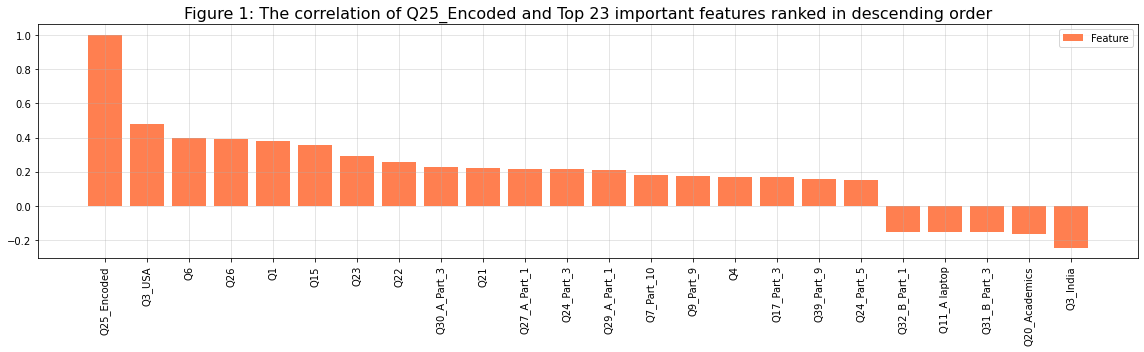

In [ ]:
# Plot correlation plot to visualize the order of feature importance among those selected 23 features and target variable
fig, ax = plt.subplots(figsize = (16,5))
plt.bar(corr_rank.index, corr_rank, label = "Feature", color = "coral")

#Formatting
plt.xticks(rotation = 90)
ax.legend()
plt.title("Figure 1: The correlation of Q25_Encoded and Top 23 important features ranked in descending order", fontsize = 16)
plt.grid(alpha = 0.4)
plt.tight_layout()
plt.show()

In [ ]:
print("As seen in the Figure1, arrtibute: Q3_USA (residence country is US) is mostly related to survey respondents' yearly compensations. \n")
print("Furthermore, Q6(Years of programming), Q26(Money spent on ML and cloud computing),Q1(Age group), Q15(Years of machine learning) are also closely related to the yearly compensation ")

As seen in the Figure1, arrtibute: Q3_USA (residence country is US) is mostly related to survey respondents' yearly compensations. 

Furthermore, Q6(Years of programming), Q26(Money spent on ML and cloud computing),Q1(Age group), Q15(Years of machine learning) are also closely related to the yearly compensation 


In [ ]:
# Filter only Top 23 correlated features and target variable on the training data to get df3_train
df3_train = df2_train[['Q25_Encoded','Q3_United States of America','Q6','Q26','Q1','Q15','Q23','Q22',
          'Q30_A_Part_3','Q21', 'Q27_A_Part_1','Q24_Part_3','Q29_A_Part_1','Q7_Part_10','Q9_Part_9',
          'Q4','Q17_Part_3','Q39_Part_9', 'Q24_Part_5','Q32_B_Part_1','Q11_A laptop','Q31_B_Part_3',
          'Q20_Academics/Education','Q3_India']]

#Calculate correlation 
correlation = df3_train.corr()

#Filter correlations with only correlation with target variable more than 0.15
#corr = correlation[abs(correlation['Q25_Encoded'])>=0.15]

#Rename the feature name to faciliate latter graphing 
correlation.rename(columns = {
    'Q3_United States of America': 'Q3_USA',
    'Q20_Academics/Education':'Q20_Academics'},
            index = {
    'Q3_United States of America': 'Q3_USA',
    'Q20_Academics/Education':'Q20_Academics'}, inplace = True)


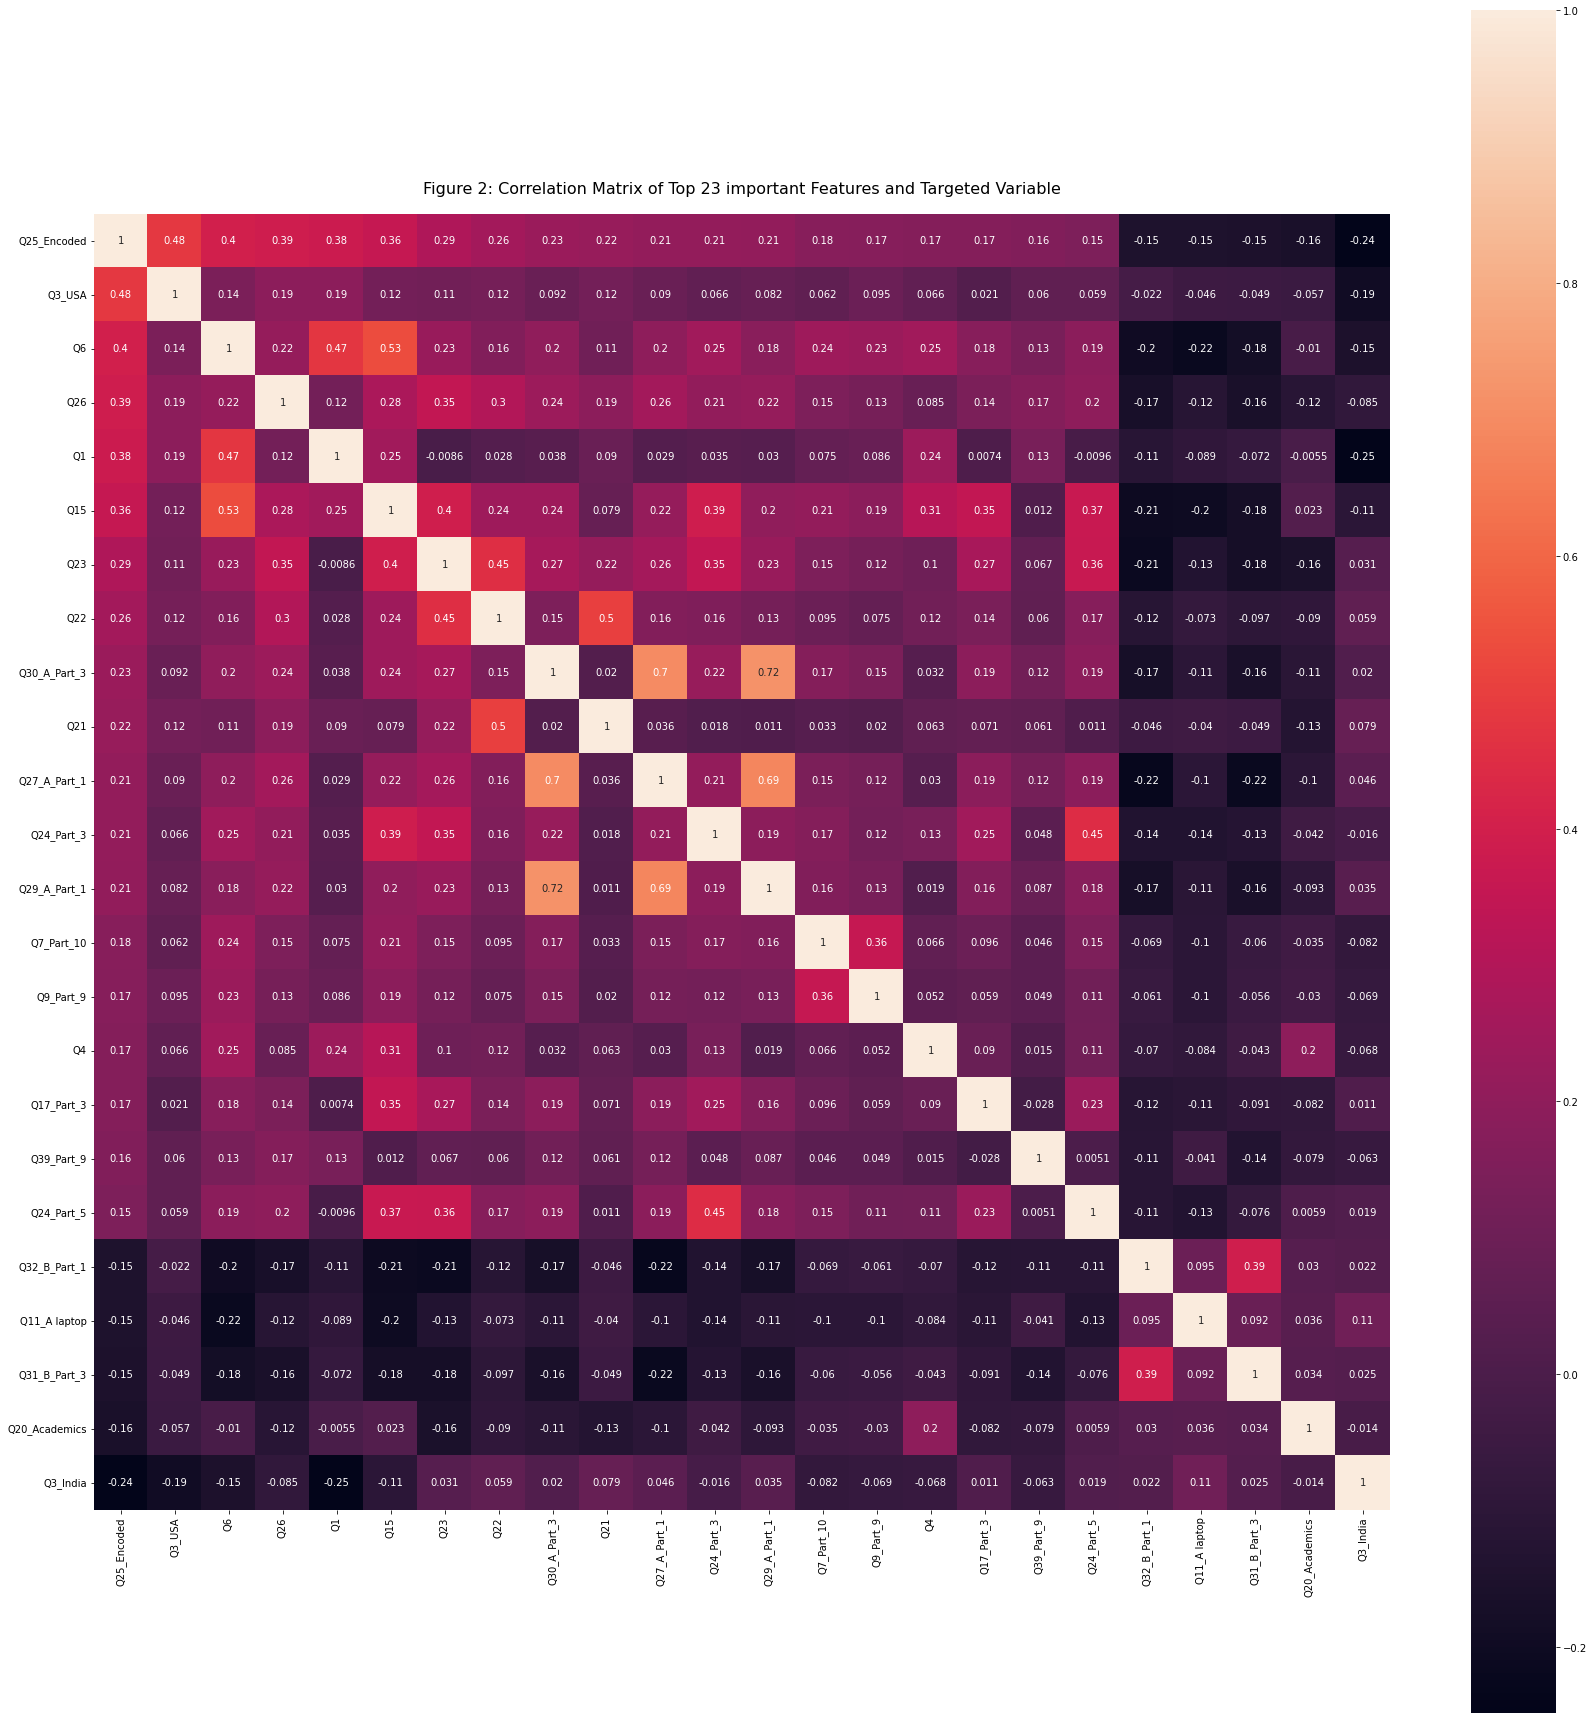

In [ ]:
#Plot the correlation matrix of Top 23 features and target variable
fig, ax = plt.subplots(figsize = (24,24))
sns.heatmap(correlation, xticklabels= correlation.columns, yticklabels = correlation.columns, annot = True, square = True, alpha = 1)
plt.title('Figure 2: Correlation Matrix of Top 23 important Features and Targeted Variable', fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()




In [ ]:
print("The benefits of feature engineering:\n")
print("Feature engineering is a useful tool which helps us to select good features to be included in the model and exclude the bad features.\n")
print("The model with good features could give more precise predictions.\n")
print ("Feature engineering could not help us to train a more precise predictive model, but also could give us a less complex model, further improving the running velocity.\n")


The benefits of feature engineering:

Feature engineering is a useful tool which helps us to select good features to be included in the model and exclude the bad features.

The model with good features could give more precise predictions.

Feature engineering could not help us to train a more precise predictive model, but also could give us a less complex model, further improving the running velocity.



In [ ]:
print ("The justification of my process of feature engineering are shown in below:\n ")
print("In this assignment, I use one of the feature engineering technique: Correlation Value to choose the significant features.\n")
print("Good features mean those features have high correlation with the target variable and have low correlation with other selected features.\n")
print("I apply the correlation this feature engineering technique to choose the important features whose correlation with Q25_Encoded > 0.15.\n")
print("The reasons of choosing correlation = 0.15 as boundary to select the features are: \n")
print("1. I want to include certain amount of features in the model since raising the boundary would significnatly reduce the number of features (large proportion of selected features have correlation from 0.15 to 0.2.)\n")
print("2. I also want to include those negative correlations at around 0.15 since both of positive and negative correlations worth further studying. I am interested in those negative correlations. Only including features who have positive correlation with target variable may not give comprehensive analysis.\n ")
print("3. Lowering the boundary would result in the excessive amount of features and may cause the excessive complexity of model. Furthermore, the correlation below 0.15 is too low to be worth studying.\n")
print("Based on above three reasons, I think 0.15 is the appropriate boundary and choose 0.15 as correlation boundary to select the features.")


The justification of my process of feature engineering are shown in below:
 
In this assignment, I use one of the feature engineering technique: Correlation Value to choose the significant features.

Good features mean those features have high correlation with the target variable and have low correlation with other selected features.

I apply the correlation this feature engineering technique to choose the important features whose correlation with Q25_Encoded > 0.15.

The reasons of choosing correlation = 0.15 as boundary to select the features are: 

1. I want to include certain amount of features in the model since raising the boundary would significnatly reduce the number of features (large proportion of selected features have correlation from 0.15 to 0.2.)

2. I also want to include those negative correlations at around 0.15 since both of positive and negative correlations worth further studying. I am interested in those negative correlations. Only including features who have posit

In [ ]:
print("As seen in above correlation plot and correlation matrix, we get the Top23 important features' correlations with Q25_Encoded and also the correlations with other selected features.\n")
print("These selected 23 features look good. They have high correlation with target variable and low correlation with any other selected features to avoid multicollinearity. Thus, I decide to include those top 23 features in the latter model.")

As seen in above correlation plot and correlation matrix, we get the Top23 important features' correlations with Q25_Encoded and also the correlations with other selected features.

These selected 23 features look good. They have high correlation with target variable and low correlation with any other selected features to avoid multicollinearity. Thus, I decide to include those top 23 features in the latter model.


In [ ]:
#Filter both of training and testing data with selected Top 23 important features 
x_train = x_train[['Q3_United States of America','Q6','Q26','Q1','Q15','Q23','Q22',
          'Q30_A_Part_3','Q21', 'Q27_A_Part_1','Q24_Part_3','Q29_A_Part_1','Q7_Part_10','Q9_Part_9',
          'Q4','Q17_Part_3','Q39_Part_9', 'Q24_Part_5','Q32_B_Part_1','Q11_A laptop','Q31_B_Part_3',
          'Q20_Academics/Education','Q3_India']]

x_test = x_test [['Q3_United States of America','Q6','Q26','Q1','Q15','Q23','Q22',
          'Q30_A_Part_3','Q21', 'Q27_A_Part_1','Q24_Part_3','Q29_A_Part_1','Q7_Part_10','Q9_Part_9',
          'Q4','Q17_Part_3','Q39_Part_9', 'Q24_Part_5','Q32_B_Part_1','Q11_A laptop','Q31_B_Part_3',
          'Q20_Academics/Education','Q3_India']]

# 3. Model Implementation

In [ ]:
# To see the number of the classes of target variable 
df['Q25_Encoded'].unique()

array([ 2.,  6.,  0.,  3.,  1.,  7., 10.,  4.,  5., 14., 13., 11.,  8.,
        9., 12.])

In [ ]:
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (10773, 23)
X_test shape:  (4618, 23)
y_train shape:  (10773,)
y_test shape:  (4618,)


In [ ]:
#Write the function of ordinal logistic regression algorithms 
def ordinal_logit_reg(x_train, y_train, x_test, C, penalty, solver):
    
    
    model = LogisticRegression(C=C, penalty = penalty, solver = solver) #Create a logistic model 
    prev_prob = np.zeros(len(x_test)) #Create the array to store the predicted probabilities
#Create the matrix to store the corresponding probability of each x_testing data point belonging into each of salary bucket 
    prob_matrix = np.zeros((len(x_test),15)) 
    
    #standardize the data 
    scaler = StandardScaler() 
    x_train = scaler.fit_transform(x_train) #Standardize the x training data 
    x_test = scaler.transform(x_test) #Standardize the x test data 

# Since Q25_Encoded has 15 classess, for multiple-classes logistic regression, we only need to do 14 times of for loops
# to get the probability of the data point falling in each salary bucket 
# Note: (For the 15th one, just using 1 -  previous 14 probabilities to get, no need of for loop for 15th one).
    for num in range(14):
# to make each class of Q25_Encoded as binary variable, for the multiple-class logistic regression, we will do the 
# binary classfication multiple times (15 times). 
        bi = np.vectorize(lambda x: 0 if x <= num else 1) 
        y_train_bi = bi(y_train) 
        
        
        model.fit(x_train, y_train_bi) #Fit the logistic regression for x_train and y_train_bi (Vectorize y_train as binary variable)
       
        
        bi_prob = model.predict_proba(x_test)[:, 0] #predict the the probability of test data and get the probabiltiy of y = 0
        
#Write a function to get rid of negative probabilities (negative probabilities make no sense)     
        adjust_negative_to_0 = np.vectorize(lambda x: 0 if x <0 else x) 
    
#Probability of (Class 1 to Classi) - Probability (Class 1 to Class i-1) = Probability of Class i 
        class_i_prob = adjust_negative_to_0(bi_prob - prev_prob) 
        prob_matrix[:,num] = class_i_prob
        
#For probability of belonging to 15th class, use 1 - probability of (previous 14 classes)        
        if num == 13: 
            prob_matrix[: , num+1] = 1 - bi_prob

#Set bi_prob as prev_prob to facilitate the following loop
        prev_prob = bi_prob 

#select the maxmized probability which is also the prediction (E.g. data point belongs to which salary bucket) for each data point
        predictions = np.argmax(prob_matrix, axis =1)
        
    
    return predictions
    

In [ ]:
#The reason of standardizing the data
print("I have applied scaling on the training data and testing data. From my own research, feature scaling is preferred but not required for the ordinal logistic regression.\n")
print("Even though it is not required, the scaling could make the convergence of the technique used for optimization more faster.\n")
print("Thus, to improve its convergence velocity,I still apply the feature scaling on data, which is more helpful for me to implement the model on bunch of data.")

I have applied scaling on the training data and testing data. From my own research, feature scaling is preferred but not required for the ordinal logistic regression.

Even though it is not required, the scaling could make the convergence of the technique used for optimization more faster.

Thus, to improve its convergence velocity,I still apply the feature scaling on data, which is more helpful for me to implement the model on bunch of data.


In [ ]:
# Write the function of conducting 10 - fold cross validation on the training data 
def ten_fold_cv (x_train, y_train, C, penalty, solver , n_splits = 10):
    kfold = KFold (n_splits = 10) #Get 10 splits 
    kfold.get_n_splits(x_train) #split the x training data into 10 partitions 

    accuracy = np.zeros (10) #Create an array to store the accuracies of 10 models 
    np_idx =0 #Create an index helping to store ACC into the previously created array 
    
    for train_idx, val_idx in kfold.split(x_train):
        #Split whole training data into the training one and the validation one 
        x_train_cv, x_val_cv = x_train.values[train_idx], x_train.values[val_idx] 
        y_train_cv, y_val_cv = y_train.values[train_idx], y_train.values[val_idx] 
 
        #Run the ordinal logistic regression on the x_validation data set to get the predictions 
        pred = ordinal_logit_reg(x_train_cv, y_train_cv, x_val_cv, C = C, penalty = penalty, solver = solver)
        
        accuracyscore = accuracy_score(y_val_cv, pred) #Calculate accuracy score for each model 
        
        accuracy[np_idx] = accuracyscore # Store ACC into the previoously created array 
        np_idx = np_idx +1
        
    return accuracy

        
        

In [ ]:
#Treating each value of hyperparameters as a new model, find the optimal model with that optimal hypeparameter 
print("In here, I choose the hyperparameter C (inverse of regularization strength) with different values to perform analysis and find the optimal model.")

In here, I choose the hyperparameter C (inverse of regularization strength) with different values to perform analysis and find the optimal model.


In [ ]:
print("More specifically, given the solver = 'liblinear' and penalty = 'l1'," )
print("I perform the total of 9 models on the training data (here refers to x_train) using 10-fold cross-validation with different values of C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100] repsectively.\n")
print("I try to find the optimal model with otpimal value of hyperparameter C and also the pattern/trend of model accuracy with the increase size of C.")

More specifically, given the solver = 'liblinear' and penalty = 'l1',
I perform the total of 9 models on the training data (here refers to x_train) using 10-fold cross-validation with different values of C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100] repsectively.

I try to find the optimal model with otpimal value of hyperparameter C and also the pattern/trend of model accuracy with the increase size of C.


In [ ]:
# Compare the accuracy of models with different C (Inverse of regularization strength) based on the validation performance
# I have commented all codes below following the assignment instructions since it takes long time to run 
# and I have also hard code the results below for each model (model1 - model9)

#accuracy1 = ten_fold_cv(x_train, y_train, C=0.001, penalty='l1', solver = "liblinear")
#accuracy2 = ten_fold_cv(x_train, y_train, C=0.01, penalty = 'l1', solver = 'liblinear')
#accuracy3 = ten_fold_cv(x_train, y_train, C=0.05, penalty = 'l1', solver = 'liblinear')
#accuracy4 = ten_fold_cv(x_train, y_train, C=0.1, penalty='l1', solver = "liblinear")
#accuracy5 = ten_fold_cv(x_train, y_train, C=0.5, penalty = 'l1', solver = 'liblinear')
#accuracy6 = ten_fold_cv(x_train, y_train, C=1, penalty = 'l1', solver = 'liblinear')
#accuracy7 = ten_fold_cv(x_train, y_train, C=5, penalty='l1', solver = "liblinear")
#accuracy8 = ten_fold_cv(x_train, y_train, C=10, penalty = 'l1', solver = 'liblinear')
#accuracy9 = ten_fold_cv(x_train, y_train, C=100, penalty = 'l1', solver = 'liblinear')

In [ ]:
# Model results based on validation performance 
#print("For the model1 with C = 0.001, the accuracy1 is {0}.\n The mean of accuracy1 is {1:.4f} and the variance of accuracy1 is {2:.4f}.\n".format(accuracy1, accuracy1.mean(),accuracy1.var()))
#print("For the model2 with C = 0.01, the accuracy2 is {0}.\n The mean of accuracy2 is {1:.4f} and the variance of accuracy2 is {2:.4f}.\n".format(accuracy2, accuracy2.mean(),accuracy2.var()))
#print("For the model3 with C = 0.05, the accuracy3 is {0}.\n The mean of accuracy3 is {1:.4f} and the variance of accuracy3 is {2:.4f}.\n".format(accuracy3, accuracy3.mean(),accuracy3.var()))
#print("For the model4 with C = 0.1, the accuracy4 is {0}.\n The mean of accuracy4 is {1:.4f} and the variance of accuracy4 is {2:.4f}.\n".format(accuracy4, accuracy4.mean(),accuracy4.var()))
#print("For the model5 with C = 0.5, the accuracy5 is {0}.\n The mean of accuracy5 is {1:.4f} and the variance of accuracy5 is {2:.4f}.\n".format(accuracy5, accuracy5.mean(),accuracy5.var()))
#print("For the model6 with C = 1, the accuracy6 is {0}.\n The mean of accuracy6 is {1:.4f} and the variance of accuracy6 is {2:.4f}.\n".format(accuracy6, accuracy6.mean(),accuracy6.var()))
#print("For the model7 with C = 5, the accuracy7 is {0}.\n The mean of accuracy7 is {1:.4f} and the variance of accuracy7 is {2:.4f}.\n".format(accuracy7, accuracy7.mean(),accuracy7.var()))
#print("For the model8 with C = 10, the accuracy8 is {0}.\n The mean of accuracy8 is {1:.4f} and the variance of accuracy8 is {2:.4f}.\n".format(accuracy8, accuracy8.mean(),accuracy8.var()))
#print("For the model9 with C = 100, the accuracy9 is {0}.\n The mean of accuracy9 is {1:.4f} and the variance of accuracy9 is {2:.4f}.\n".format(accuracy9, accuracy9.mean(),accuracy9.var()))



In [ ]:
#Hard coded model results based on validation folds performance 
print('For the model1 with C = 0.001, the accuracy1 is [0.44990724 0.45732839 0.46011132 0.48189415 0.44103993 0.46425255 0.45868152 0.45311049 0.45682451 0.45125348].\nThe mean of accuracy1 is 0.4574 and the variance of accuracy1 is 0.0001.\n')
print('For the model2 with C = 0.01, the accuracy2 is [0.46567718 0.4703154  0.46846011 0.49953575 0.45682451 0.4735376 0.47818013 0.46703807 0.46332405 0.47075209].\nThe mean of accuracy2 is 0.4714 and the variance of accuracy2 is 0.0001.\n')
print('For the model3 with C = 0.05, the accuracy3 is [0.46753247 0.47309833 0.47680891 0.49767874 0.45311049 0.47539461 0.47725162 0.46982358 0.47725162 0.47725162].\nThe mean of accuracy3 is 0.4745 and the variance of accuracy3 is 0.0001.\n')
print('For the model4 with C = 0.1, the accuracy4 is [0.46753247 0.47124304 0.48144712 0.49860724 0.4549675 0.4726091 0.47446611 0.46982358 0.47910864 0.4726091 ].\nThe mean of accuracy4 is 0.4742 and the variance of accuracy4 is 0.0001.\n')
print('For the model5 with C = 0.5, the accuracy5 is [0.46846011 0.47217069 0.48144712 0.49860724 0.45589601 0.4735376 0.47632312 0.46796657 0.47725162 0.47075209].\nThe mean of accuracy5 is 0.4742 and the variance of accuracy5 is 0.0001.\n')
print('For the model6 with C = 1, the accuracy6 is [0.46846011 0.47309833 0.48051948 0.49767874 0.45589601 0.4735376 0.47446611 0.46796657 0.47725162 0.47168059].\nThe mean of accuracy6 is 0.4741 and the variance of accuracy6 is 0.0001.\n')
print('For the model7 with C = 5, the accuracy7 is [0.47124304 0.47309833 0.47866419 0.49675023 0.45589601 0.4735376 0.4735376  0.46889508 0.47725162 0.47075209].\nThe mean of accuracy7 is 0.4740 and the variance of accuracy7 is 0.0001.\n')
print('For the model8 with C = 10, the accuracy8 is [0.4703154 0.47309833 0.47866419 0.49675023 0.45589601 0.4735376 0.4735376  0.46889508 0.47725162 0.46982358].\nThe mean of accuracy8 is 0.4738 and the variance of accuracy8 is 0.0001.\n')
print('For the model9 with C = 100, the accuracy9 is [0.4703154  0.47309833 0.47866419 0.49675023 0.45589601 0.4735376 0.4735376  0.46889508 0.47725162 0.46889508].\nThe mean of accuracy9 is 0.4736 and the variance of accuracy9 is 0.0001.')



For the model1 with C = 0.001, the accuracy1 is [0.44990724 0.45732839 0.46011132 0.48189415 0.44103993 0.46425255 0.45868152 0.45311049 0.45682451 0.45125348].
The mean of accuracy1 is 0.4574 and the variance of accuracy1 is 0.0001.

For the model2 with C = 0.01, the accuracy2 is [0.46567718 0.4703154  0.46846011 0.49953575 0.45682451 0.4735376 0.47818013 0.46703807 0.46332405 0.47075209].
The mean of accuracy2 is 0.4714 and the variance of accuracy2 is 0.0001.

For the model3 with C = 0.05, the accuracy3 is [0.46753247 0.47309833 0.47680891 0.49767874 0.45311049 0.47539461 0.47725162 0.46982358 0.47725162 0.47725162].
The mean of accuracy3 is 0.4745 and the variance of accuracy3 is 0.0001.

For the model4 with C = 0.1, the accuracy4 is [0.46753247 0.47124304 0.48144712 0.49860724 0.4549675 0.4726091 0.47446611 0.46982358 0.47910864 0.4726091 ].
The mean of accuracy4 is 0.4742 and the variance of accuracy4 is 0.0001.

For the model5 with C = 0.5, the accuracy5 is [0.46846011 0.4721706

In [ ]:
print("As seen in above models, the model accuracy across the fold has a small difference but this difference is acceptable.\n")
print("For each model built, the average of accuracy and the variance of accuracy are shown in the above.\n")
print("Overall, the average of accuracy for folds is approximately 0.47,the variance of accuracy for folds is 0.0001.")

As seen in above models, the model accuracy across the fold has a small difference but this difference is acceptable.

For each model built, the average of accuracy and the variance of accuracy are shown in the above.

Overall, the average of accuracy for folds is approximately 0.47,the variance of accuracy for folds is 0.0001.


In [ ]:
print("As seen the above results based on validation performance, the optimal C is C = 0.05. The model with solver = 'liblinear', penalty = 'l1', C = '0.05' performs best.\n")
print ("This optimal model is the model3, which has the mean of accuracy = 0.4745, the variance of accuracy = 0.0001")


As seen the above results based on validation performance, the optimal C is C = 0.05. The model with solver = 'liblinear', penalty = 'l1', C = '0.05' performs best.

This optimal model is the model3, which has the mean of accuracy = 0.4745, the variance of accuracy = 0.0001


In [ ]:
print("Above optimal model selected is based on the validation performance.\n")
print("In the following, I am going to double check whether above model is exactly the optimal model and explain why above model is the optimal model from the bias-variance trade-off perspective.\n")
print("To study this from the bias-variance trade-off perspective, besides the previous validation folds performance gained, I will also perform the model and obtain the model accuracy based on training folds performance.\n")
print("Then I will compare the model accuracy between the training folds performance and validation folds performance to do the following tasks:")
print("1. Illustrate the trend of model accuracy on training folds vs validation folds with the increase of C")
print("2. Whether the model is underfitting vs overfitting")
print("3. How to approach the optimal model from the bias-variance trade-off view.")


Above optimal model selected is based on the validation performance.

In the following, I am going to double check whether above model is exactly the optimal model and explain why above model is the optimal model from the bias-variance trade-off perspective.

To study this from the bias-variance trade-off perspective, besides the previous validation folds performance gained, I will also perform the model and obtain the model accuracy based on training folds performance.

Then I will compare the model accuracy between the training folds performance and validation folds performance to do the following tasks:
1. Illustrate the trend of model accuracy on training folds vs validation folds with the increase of C
2. Whether the model is underfitting vs overfitting
3. How to approach the optimal model from the bias-variance trade-off view.


In [ ]:
print("Below is the function of perform the ordinal logistic algorithm and obtain the model accuracy based on the training folds performance.")

Below is the function of perform the ordinal logistic algorithm and obtain the model accuracy based on the training folds performance.


In [ ]:
# Write the function of conducting 10 - fold cross validation on the training data based on the training folds performance
def cv_on_train (x_train, y_train, C, penalty, solver , n_splits = 10):
    kfold = KFold (n_splits = 10) #Get 10 splits 
    kfold.get_n_splits(x_train) #split the x training data into 10 partitions 

    accuracy = np.zeros (10) #Create an array to store the accuracies of 10 models 
    np_idx =0 #Create an index helping to store ACC into the previously created array 
    
    for train_idx, val_idx in kfold.split(x_train):
        #Split whole training data into the training folds and the validation folds
        x_train_cv, x_val_cv = x_train.values[train_idx], x_train.values[val_idx] 
        y_train_cv, y_val_cv = y_train.values[train_idx], y_train.values[val_idx] 
 
        #Fit ordinal logistic regression on the training fold and then run the model on training folds again to get the predictions 
        pred = ordinal_logit_reg(x_train_cv, y_train_cv, x_train_cv, C = C, penalty = penalty, solver = solver)
        
        #Calculate the accuracy score based on predictions (from training folds) and the actual y training folds values
        accuracyscore = accuracy_score(y_train_cv, pred) 
        accuracy[np_idx] = accuracyscore # Store ACC into the previously created array 
        np_idx = np_idx +1
        
    return accuracy

In [ ]:
# Compare the accuracy of models with different C (Inverse of regularization strength) based on training folds performance
# I have commented all codes below following the assignment instructions since it takes long time to run 
# and I have also hard code the results below for each model (model1_train - model9_train)
#accuracy1_train = cv_on_train(x_train, y_train, C=0.001, penalty='l1', solver = "liblinear")
#accuracy2_train = cv_on_train(x_train, y_train, C=0.01, penalty = 'l1', solver = 'liblinear')
#accuracy3_train = cv_on_train(x_train, y_train, C=0.05, penalty = 'l1', solver = 'liblinear')
#accuracy4_train = cv_on_train(x_train, y_train, C=0.1, penalty='l1', solver = "liblinear")
#accuracy5_train = cv_on_train(x_train, y_train, C=0.5, penalty = 'l1', solver = 'liblinear')
#accuracy6_train = cv_on_train(x_train, y_train, C=1, penalty = 'l1', solver = 'liblinear')
#accuracy7_train = cv_on_train(x_train, y_train, C=5, penalty='l1', solver = "liblinear")
#accuracy8_train = cv_on_train(x_train, y_train, C=10, penalty = 'l1', solver = 'liblinear')
#accuracy9_train = cv_on_train(x_train, y_train, C=100, penalty = 'l1', solver = 'liblinear')

In [ ]:
# Model results based on training folds performance 
#print("For the model1_train with C = 0.001, the accuracy1_train is {0}.\n The mean of accuracy1_train is {1:.4f} and the variance of accuracy1_train is {2:.4f}.\n".format(accuracy1_train, accuracy1_train.mean(),accuracy1_train.var()))
#print("For the model2_train with C = 0.01, the accuracy2_train is {0}.\n The mean of accuracy2_train is {1:.4f} and the variance of accuracy2_train is {2:.4f}.\n".format(accuracy2_train, accuracy2_train.mean(),accuracy2_train.var()))
#print("For the model3_train with C = 0.05, the accuracy3_train is {0}.\n The mean of accuracy3_train is {1:.4f} and the variance of accuracy3_train is {2:.4f}.\n".format(accuracy3_train, accuracy3_train.mean(),accuracy3_train.var()))
#print("For the model4_train with C = 0.1, the accuracy4_train is {0}.\n The mean of accuracy4_train is {1:.4f} and the variance of accuracy4_train is {2:.4f}.\n".format(accuracy4_train, accuracy4_train.mean(),accuracy4_train.var()))
#print("For the model5_train with C = 0.5, the accuracy5_train is {0}.\n The mean of accuracy5_train is {1:.4f} and the variance of accuracy5_train is {2:.4f}.\n".format(accuracy5_train, accuracy5_train.mean(),accuracy5_train.var()))
#print("For the model6_train with C = 1, the accuracy6_train is {0}.\n The mean of accuracy6_train is {1:.4f} and the variance of accuracy6_train is {2:.4f}.\n".format(accuracy6_train, accuracy6_train.mean(),accuracy6_train.var()))
#print("For the model7_train with C = 5, the accuracy7_train is {0}.\n The mean of accuracy7_train is {1:.4f} and the variance of accuracy7_train is {2:.4f}.\n".format(accuracy7_train, accuracy7_train.mean(),accuracy7_train.var()))
#print("For the model8_train with C = 10, the accuracy8_train is {0}.\n The mean of accuracy8_train is {1:.4f} and the variance of accuracy8_train is {2:.4f}.\n".format(accuracy8_train, accuracy8_train.mean(),accuracy8_train.var()))
#print("For the model9_train with C = 100, the accuracy9_train is {0}.\n The mean of accuracy9_train is {1:.4f} and the variance of accuracy9_train is {2:.4f}.\n".format(accuracy9_train, accuracy9_train.mean(),accuracy9_train.var()))



In [ ]:
#hard coded model results based on training folds performance 
print('For the model1_train with C = 0.001, the accuracy1_train is [0.45827746 0.45745229 0.45714286 0.4547236 0.45926155 0.45668317 0.45730198 0.45792079 0.45750825 0.45812706].\nThe mean of accuracy1_train is 0.4574 and the variance of accuracy1_train is 0.0000.\n')
print('For the model2_train with C = 0.01, the accuracy2_train is [0.47374936 0.4725116  0.47405879 0.47101898 0.47442244 0.47349422 0.47143152 0.4740099  0.47328795 0.47308168].\nThe mean of accuracy2_train is 0.4731 and the variance of accuracy2_train is 0.0000.\n')
print('For the model3_train with C = 0.05, the accuracy3_train is [0.47952553 0.47828778 0.47684373 0.47627888 0.48040429 0.47803218 0.47731023 0.47803218 0.4772071  0.47803218].\nThe mean of accuracy3_train is 0.4780 and the variance of accuracy3_train is 0.0000.\n')
print('For the model4_train with C = 0.1, the accuracy4_train is [0.47983497 0.47839092 0.4776689  0.47700083 0.48081683 0.47834158 0.47782591 0.47937294 0.47658828 0.47813531].\nThe mean of accuracy4_train is 0.4784 and the variance of accuracy4_train is 0.0000.\n')
print('For the model5_train with C = 0.5, the accuracy5_train is [0.47921609 0.47962867 0.4776689  0.4772071  0.48112624 0.48019802 0.47865099 0.47916667 0.47803218 0.47875413].\nThe mean of accuracy5_train is 0.4790 and the variance of accuracy5_train is 0.0000.\n')
print('For the model6_train with C = 1, the accuracy6_train is [0.47890665 0.47952553 0.47746261 0.47731023 0.4810231  0.48030116 0.47865099 0.47957921 0.47803218 0.47834158].\nThe mean of accuracy6_train is 0.4789 and the variance of accuracy6_train is 0.0000.\n')
print('For the model7_train with C = 5, the accuracy7_train is [0.47880351 0.47942238 0.47725632 0.4772071  0.48081683 0.48030116 0.47875413 0.47968234 0.47782591 0.47844472].\nThe mean of accuracy7_train is 0.4788 and the variance of accuracy7_train is 0.0000.\n')
print('For the model8_train with C = 10, the accuracy8_train is [0.47880351 0.47962867 0.47725632 0.47700083 0.4807137  0.48030116 0.47875413 0.47968234 0.47782591 0.47844472].\nThe mean of accuracy8_train is 0.4789 and the variance of accuracy8_train is 0.0000.\n')
print('For the model9_train with C = 100, the accuracy9_train is [0.47880351 0.47962867 0.47725632 0.47710396 0.4807137  0.48040429 0.47875413 0.47968234 0.47782591 0.47854785].\nThe mean of accuracy9_train is 0.4789 and the variance of accuracy9_train is 0.0000.')








For the model1_train with C = 0.001, the accuracy1_train is [0.45827746 0.45745229 0.45714286 0.4547236 0.45926155 0.45668317 0.45730198 0.45792079 0.45750825 0.45812706].
The mean of accuracy1_train is 0.4574 and the variance of accuracy1_train is 0.0000.

For the model2_train with C = 0.01, the accuracy2_train is [0.47374936 0.4725116  0.47405879 0.47101898 0.47442244 0.47349422 0.47143152 0.4740099  0.47328795 0.47308168].
The mean of accuracy2_train is 0.4731 and the variance of accuracy2_train is 0.0000.

For the model3_train with C = 0.05, the accuracy3_train is [0.47952553 0.47828778 0.47684373 0.47627888 0.48040429 0.47803218 0.47731023 0.47803218 0.4772071  0.47803218].
The mean of accuracy3_train is 0.4780 and the variance of accuracy3_train is 0.0000.

For the model4_train with C = 0.1, the accuracy4_train is [0.47983497 0.47839092 0.4776689  0.47700083 0.48081683 0.47834158 0.47782591 0.47937294 0.47658828 0.47813531].
The mean of accuracy4_train is 0.4784 and the variance 

In [ ]:
print("Below is the figure of model accuracy with different hyperparameter C on training folds and validation folds:")

Below is the figure of model accuracy with different hyperparameter C on training folds and validation folds:


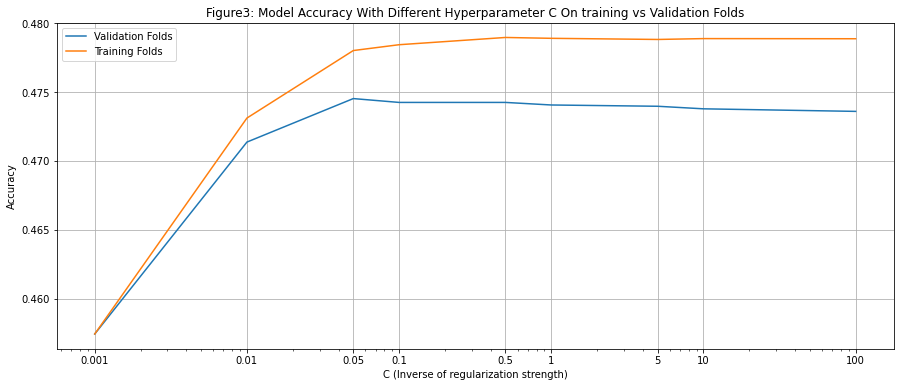

In [ ]:
#Plot Figure3: Model Accuracy With Different Hyperparameter C on training folds vs validation folds 
fig, ax = plt.subplots(figsize = (15,6))
C_list = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
#accuracy_val_list = [accuracy1.mean(),accuracy2.mean(),accuracy3.mean(),accuracy4.mean(),accuracy5.mean(),accuracy6.mean(),accuracy7.mean(),accuracy8.mean(),accuracy9.mean()]
accuracy_val_list = [0.4574403577587024,
 0.4713644890724079,
 0.47452020058466526,
 0.4742413906560345,
 0.4742412183916362,
 0.47405551737028057,
 0.4739625807274036,
 0.47377696583824724,
 0.47359135094909066]
#accuracy_train_list = [accuracy1_train.mean(),accuracy2_train.mean(),accuracy3_train.mean(),accuracy4_train.mean(),accuracy5_train.mean(),accuracy6_train.mean(),accuracy7_train.mean(),accuracy8_train.mean(),accuracy9_train.mean()]
accuracy_train_list = [0.4574399017390135,
 0.4731066462757673,
 0.4780057204727693,
 0.47842859015143385,
 0.47895458344184083,
 0.478892694807129,
 0.4788101833649069,
 0.47887206880822175,
 0.4788617531492706]
#Formatting 
plt.plot(C_list, accuracy_val_list, label='Validation Folds')
plt.plot(C_list, accuracy_train_list, label='Training Folds')
plt.grid()
plt.title("Figure3: Model Accuracy With Different Hyperparameter C On training vs Validation Folds")
plt.xscale('log')
plt.xticks(C_list, labels=C_list)
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print("As seen in the above Figure3:\n")
print("For the trend of model accuracy in training folds with the increase of C, the model accuracy shows the increasing trend initially with slower increasing rate until it gets into the stready state.\n")
print("For the trend of model accuracy in validation folds with the increase of C, the model accuracy shows the increasing trend with the slower increasing rate from C = 0.001 to C = 0.05, then the model accuracy starts to decrease from C =0.05 until it gets into the steady state.")


As seen in the above Figure3:

For the trend of model accuracy in training folds with the increase of C, the model accuracy shows the increasing trend initially with slower increasing rate until it gets into the stready state.

For the trend of model accuracy in validation folds with the increase of C, the model accuracy shows the increasing trend with the slower increasing rate from C = 0.001 to C = 0.05, then the model accuracy starts to decrease from C =0.05 until it gets into the steady state.


In [ ]:
print("As seen in the above Figure3:\n")
print("Overall, both of model accuracies for the training folds and validation folds are relatively low, which are below 50%. This indicates that the model is underfitting. That means the model experiences the high bias and low variance.")

As seen in the above Figure3:

Overall, both of model accuracies for the training folds and validation folds are relatively low, which are below 50%. This indicates that the model is underfitting. That means the model experiences the high bias and low variance.


In [ ]:
print("Since the model experiences the underfitting and both of model accuracies are low, in this case, given the increasing training folds performance, we should find the optimal model by finding the highest accuracy (lowest error) for validation folds. That means at that point, the model geeneralizes optimally compared with rest ones considering the bias-variance trade-off.\n")
print("Seen from Figure3, when C = 0.05, it has the highest model accuracy for validation folds. Thus, this point has the best bias-variance trade-off compared with the rest ones.\n")
print("In conclusion, from the bias-variance trade-off perspective, by comparing the training folds performance and validation folds performance, the model with C = 0.05 has the best bias-variance trade-off and is the optimal model.")

Since the model experiences the underfitting and both of model accuracies are low, in this case, given the increasing training folds performance, we should find the optimal model by finding the highest accuracy (lowest error) for validation folds. That means at that point, the model geeneralizes optimally compared with rest ones considering the bias-variance trade-off.

Seen from Figure3, when C = 0.05, it has the highest model accuracy for validation folds. Thus, this point has the best bias-variance trade-off compared with the rest ones.

In conclusion, from the bias-variance trade-off perspective, by comparing the training folds performance and validation folds performance, the model with C = 0.05 has the best bias-variance trade-off and is the optimal model.


# 4. Model tuning 

In [ ]:
#Define all hyperparameters
print ("Hyperparameters in my model are solver, penalty and C (Inverse of regularization strength).")

Hyperparameters in my model are solver, penalty and C (Inverse of regularization strength).


In [ ]:
print("From my own research, the type of penalty and the size of C affect the model accuracy more than the type of solver.\n")
print("Thus, I choose the penalty and C to do model tuning in the following.")

From my own research, the type of penalty and the size of C affect the model accuracy more than the type of solver.

Thus, I choose the penalty and C to do model tuning in the following.


In [ ]:
# Following the assignment instruction, I have commented out cross validation code and hard code the results of optimal model parameters 
#Grid search for optimal hyperparameters 
#best_params = {}
#best_accuracy = 0 
#best_std = 0

#for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]:     
#    for penalty in ['l1', 'l2']:
#        accuracy = ten_fold_cv(x_train, y_train, C=C, penalty = penalty, solver = "liblinear")
#       if np.mean(accuracy) > best_accuracy:
#           best_params = {'C':C, 'penalty':penalty}
#           best_accuracy = np.mean(accuracy)
#           best_std = np.std(accuracy)


#print (best_params)
#print ("Best Score: {}({})".format(round(best_accuracy,3),round(best_std,3)))      

print("{'C': 0.05, 'penalty': 'l1'}")
print('Best Score: 0.475(0.01)')

{'C': 0.05, 'penalty': 'l1'}
Best Score: 0.475(0.01)


In [ ]:
print("I conclude that the optimal model is the model with hyperparameter C = 0.05 and penalty =l1")

I conclude that the optimal model is the model with hyperparameter C = 0.05 and penalty =l1


In [ ]:
#Justification of why I use accuracy as metrics 
print("For the metrics, I choose the accuracy score as the metrics to choose the optimal model. \n")

print("This is because that in this scienario, we focus on studying whether the model could correctly predict the salary bucket to which each data point belongs.\n")
print("What we care most is the correct rate of predicting each data point into the correct salary bucket (When the prediction of salary bucket on the specific data point is equal to its actual salary bucket, then we call it 'correct salary bucket').\n")
print ("From the statistic perspective, what we care most in this muti class classfication is the true rates.\n")
print("By definition, the accuracy score refers to the measure of all the correctly identified cases. From statistic & mathematics perspective, the formula of accuracy is the (TP + TN) = (TP + TN + FP + FN) = (Correct predictions / total predictions). That is what we want.\n ")
print("In this case, we do not use F1 score or recall, etc., it is because we care correctly defined cases more than incorrectly defined cases.(From my research , accuracy is used when the True positives and True negatives are more important while F1-score is used when the False negatives and False nositives are crucial)")

For the metrics, I choose the accuracy score as the metrics to choose the optimal model. 

This is because that in this scienario, we focus on studying whether the model could correctly predict the salary bucket to which each data point belongs.

What we care most is the correct rate of predicting each data point into the correct salary bucket (When the prediction of salary bucket on the specific data point is equal to its actual salary bucket, then we call it 'correct salary bucket').

From the statistic perspective, what we care most in this muti class classfication is the true rates.

By definition, the accuracy score refers to the measure of all the correctly identified cases. From statistic & mathematics perspective, the formula of accuracy is the (TP + TN) = (TP + TN + FP + FN) = (Correct predictions / total predictions). That is what we want.
 
In this case, we do not use F1 score or recall, etc., it is because we care correctly defined cases more than incorrectly defined cases.

In [ ]:
#Plot feature importance against predictions 
#Get predictions (As clarified by TA, either test data or validation data is fine, this time i choose to predict on the testing data.)
prediction =ordinal_logit_reg(x_train, y_train, x_test, C = 0.05, solver = "liblinear", penalty = 'l1')



In [ ]:
data = {'Predictions':list(prediction), 'Q3_USA':x_test['Q3_United States of America'], 
        'Q6': x_test['Q6'], 'Q26':x_test['Q26'], 'Q1': x_test['Q1'], 'Q15':x_test['Q15'],
        'Q23':x_test['Q23'], 'Q22' : x_test['Q22'], 'Q30_A_Part_3': x_test['Q30_A_Part_3'],
        'Q21':x_test['Q21'], 'Q27_A_Part_1':x_test['Q27_A_Part_1'],'Q24_Part_3':x_test['Q24_Part_3'],
        'Q29_A_Part_1':x_test['Q29_A_Part_1'], 'Q7_Part_10': x_test['Q7_Part_10'],  'Q9_Part_9': x_test['Q9_Part_9'],
        'Q4':x_test['Q4'],'Q17_Part_3':x_test['Q17_Part_3'], 'Q39_Part_9':x_test['Q39_Part_9'],
         'Q24_Part_5':x_test['Q24_Part_5'], 'Q32_B_Part_1': x_test['Q32_B_Part_1'], 'Q11_A laptop':x_test['Q11_A laptop'],
        'Q31_B_Part_3':x_test['Q31_B_Part_3'], 'Q20_Academics': x_test['Q20_Academics/Education'],
        'Q3_India': x_test['Q3_India']}


df4= pd.DataFrame(data)

corr_rank_pred = df4.corr()['Predictions'].sort_values(ascending= False)




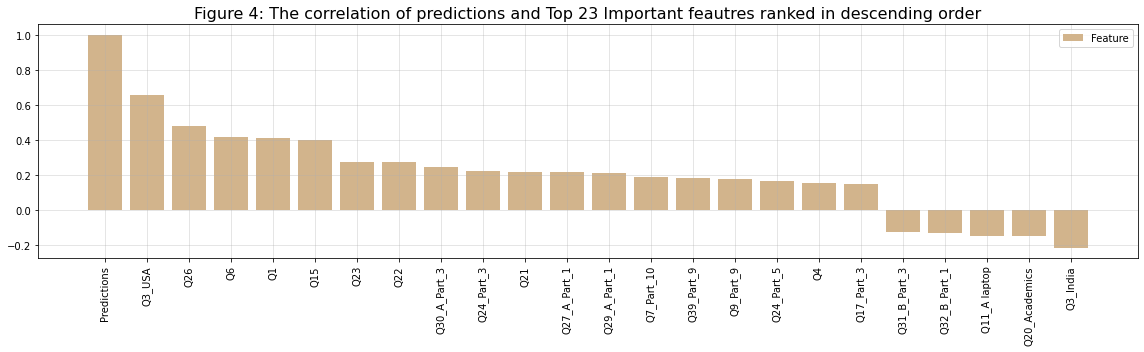

In [ ]:
#Plot correlation plot to visualize the order of feature importance against predictions 
fig,ax = plt.subplots(figsize = (16,5))
plt.bar(corr_rank_pred.index, corr_rank_pred, label = 'Feature', color = 'tan')

#Formatting 
plt.xticks(rotation = 90)
ax.legend()
plt.title("Figure 4: The correlation of predictions and Top 23 Important feautres ranked in descending order", fontsize = 16)
plt.grid(alpha = 0.4)
plt.tight_layout()
plt.show()

In [ ]:
print("As seen in Figure4, the most determing feature in model predictions is Q3_USA (Residence country is America).Furthermore, Q26, Q6, Q1, Q15 all play the important role in determing predictions.")

As seen in Figure4, the most determing feature in model predictions is Q3_USA (Residence country is America).Furthermore, Q26, Q6, Q1, Q15 all play the important role in determing predictions.


In [ ]:
print("Comparing the Figure 1 and Figure 4 these two correlation plots, we can find that both of the most determining in feature (against actual target values & against predictions) are Q3_USA.\n")
print("Then in both correlation plots, Q26, Q1,Q5,Q6 are highly correlated with both of actual target values and predictions. However, the importance rank of these 4 features are different in two correlation plots.\n")
print("There are also differences in the rank of other releatively less important features among these two correlation plots (against actual target values vs against predictions).")

Comparing the Figure 1 and Figure 4 these two correlation plots, we can find that both of the most determining in feature (against actual target values & against predictions) are Q3_USA.

Then in both correlation plots, Q26, Q1,Q5,Q6 are highly correlated with both of actual target values and predictions. However, the importance rank of these 4 features are different in two correlation plots.

There are also differences in the rank of other releatively less important features among these two correlation plots (against actual target values vs against predictions).


# 5. Testing & Discussion 

In [ ]:
#Use optimal model to make classifications on the test set
y_test_pred = ordinal_logit_reg (x_train, y_train, x_test, C = 0.05, penalty = 'l1', solver = 'liblinear')
#Use optimal model to make classifications on the training set
y_train_pred = ordinal_logit_reg (x_train, y_train, x_train, C = 0.05, penalty = 'l1', solver = 'liblinear')

#Obtain the model accuracy for the testing set and training set 
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


In [ ]:
print("The model accuracy on the training set is {0} and the model accuracy on the testing set is {1}".format(train_accuracy, test_accuracy))

The model accuracy on the training set is 0.47767567065812677 and the model accuracy on the testing set is 0.46470333477695974


In [ ]:
print("Given the low accuracies for both of training set and testing set, it indicates that the model is underfitting. It experiences high bias and low variance.\n")
print("To improve the model accuracy, we can take possible measure below:")
print("1. Increase more training data.")
print("2. Increase the complexity of model by increasing more parameters.")


Given the low accuracies for both of training set and testing set, it indicates that the model is underfitting. It experiences high bias and low variance.

To improve the model accuracy, we can take possible measure below:
1. Increase more training data.
2. Increase the complexity of model by increasing more parameters.


In [ ]:
print("Above measure is the general measure to handle with the underfitting. By looking into the predictions vs actual values on training vs testing set. I find more accurate reasons leading to the underfitting and put forward more pertinent&effective measures.")

Above measure is the general measure to handle with the underfitting. By looking into the predictions vs actual values on training vs testing set. I find more accurate reasons leading to the underfitting and put forward more pertinent&effective measures.


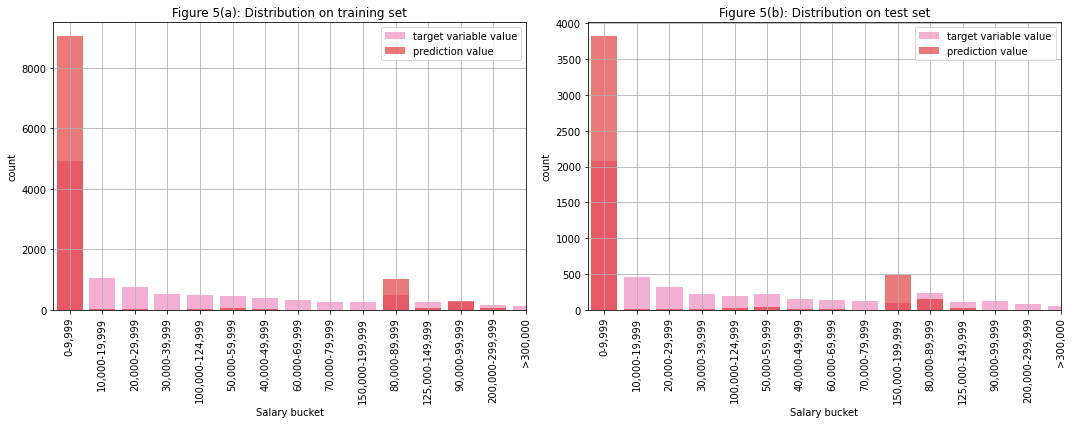

In [ ]:
#Plot the distribution of true target variable values and their predictions on both training set and testing set 
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (15,6))

sns.countplot(x=y_train, color = "hotpink", alpha = 0.6, label = "target variable value", ax= ax1)
sns.countplot(x=y_train_pred, color = "red", alpha = 0.6, label = "prediction value", ax= ax1)
sns.countplot(x=y_test, color = "hotpink", alpha = 0.6, label = "target variable value", ax= ax2)
sns.countplot(x=y_test_pred, color = "red", alpha = 0.6, label = "prediction value", ax= ax2)

#Formatting 
ax1.set_title("Figure 5(a): Distribution on training set")
ax2.set_title("Figure 5(b): Distribution on test set" )
ax1.legend()
ax2.legend()

ax1.set_xlabel("Salary bucket")
ax2.set_xlabel("Salary bucket")

ax1.grid()
ax2.grid()

ax1.set_xticks(np.arange(0,15))
ax1.set_xticklabels(list(df.Q25_buckets.value_counts().index),rotation =90)

ax2.set_xticks(np.arange(0,15))
ax2.set_xticklabels(list(df.Q25_buckets.value_counts().index),rotation =90)
    
plt.tight_layout()
plt.show()
    

In [ ]:
print("As seen in Figure 5(a), for training set, the predictions falling into the 0 - $ 9,999 this salary bucket are much more than the actual values falling into this range.") 
print("The predictions falling into the $80,000 – $89,999 are also too much compared with actual values. However, the predictions are much less than the actual values in other salary buckets.\n")


print("As seen in Figure 5(b), for testing set, the predictions falling into the 0 - $ 9,999 this salary bucket are also much more than the actual values falling into this range.")
print("Furthermore, the predictions falling into $ 150,000 - $199,999 are much more than actual values falling in this range. However, the predictions are much less than the actual values in other salary buckets. ")






As seen in Figure 5(a), for training set, the predictions falling into the 0 - $ 9,999 this salary bucket are much more than the actual values falling into this range.
The predictions falling into the $80,000 – $89,999 are also too much compared with actual values. However, the predictions are much less than the actual values in other salary buckets.

As seen in Figure 5(b), for testing set, the predictions falling into the 0 - $ 9,999 this salary bucket are also much more than the actual values falling into this range.
Furthermore, the predictions falling into $ 150,000 - $199,999 are much more than actual values falling in this range. However, the predictions are much less than the actual values in other salary buckets. 


In [ ]:
print("Based on the model accuracies and Figure 5, the model does not have high performance and has the inconsistencies between predictions vs actual values on both training and testing set.\n")


Based on the model accuracies and Figure 5, the model does not have high performance and has the inconsistencies between predictions vs actual values on both training and testing set.



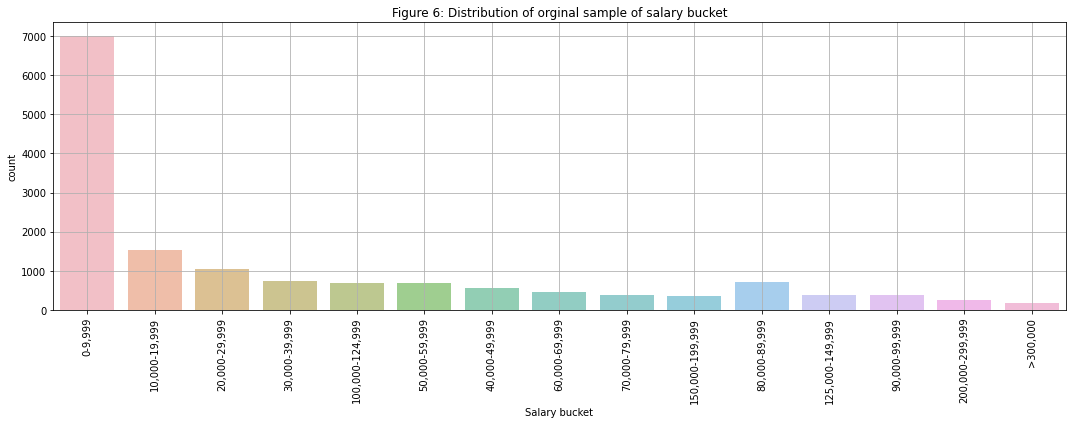

In [ ]:
#Plot the distribution of orginal sample 
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(df.Q25_Encoded, alpha = 0.6, label = "original sample", ax=ax)

#Formatting
ax.set_title("Figure 6: Distribution of orginal sample of salary bucket")
ax.set_xticks(np.arange(0,15))
ax.set_xticklabels(list(df.Q25_buckets.value_counts().index),rotation =90)
ax.set_xlabel("Salary bucket")
ax.grid()


plt.tight_layout()
plt.show()

In [ ]:
print("The main reason of it is the imbalances of original dataset. As seen in the Figure6, in the original sample, there are extremely many data points falling into the $0 - $9,999 this salary bucket (major class).\n")
print("However, there are only few data points falling in the other salary buckets, especially high salary buckets (minor class).\n")
print("The imbalances of data leads to the low predictive performance since the classification algorithms are designed around the assumption of an equal number of data for each class.\n")
print("Another reason of low accuracy is that: even though accuracy is very suitable for the context of this study, it does not deal with the imbalanced data well. There seems like a contradiction between the context of study and properties of original dataset. It is hard to make us choose the appropriate performance metrics which can meet all suitability.")

The main reason of it is the imbalances of original dataset. As seen in the Figure6, in the original sample, there are extremely many data points falling into the $0 - $9,999 this salary bucket (major class).

However, there are only few data points falling in the other salary buckets, especially high salary buckets (minor class).

The imbalances of data leads to the low predictive performance since the classification algorithms are designed around the assumption of an equal number of data for each class.

Another reason of low accuracy is that: even though accuracy is very suitable for the context of this study, it does not deal with the imbalanced data well. There seems like a contradiction between the context of study and properties of original dataset. It is hard to make us choose the appropriate performance metrics which can meet all suitability.


In [ ]:
print("After looking into the reasons leading to underfitting, to address the problems, I may put forward below measures:\n")
print("1. Try F1-score instead of accuracy (even though accuracy is more suitable for context wheras F1-score deals with imbalanced data better)\n")
print("2. Apply BalancedBaggingClassifier.\n")
print("3. Oversampling. When we are using an imbalanced dataset, we can oversample the minority class using replacement until we can get a balanced dataset for both majority and minority classes.")

After looking into the reasons leading to underfitting, to address the problems, I may put forward below measures:

1. Try F1-score instead of accuracy (even though accuracy is more suitable for context wheras F1-score deals with imbalanced data better)

2. Apply BalancedBaggingClassifier.

3. Oversampling. When we are using an imbalanced dataset, we can oversample the minority class using replacement until we can get a balanced dataset for both majority and minority classes.
